In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## DemonstrationFaceGeneration
## Description: 
# This module is responsible for fetching the FFHQ256 dataset from kaggle, downloading it and unzipping it.
#####################################################################################

In [2]:
# Install Kaggle API
!pip install kaggle

# Create the necessary directory and upload the kaggle.json file
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)  # Use expanduser to handle home directory paths correctly
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Define the output directory for the dataset
output_dir = "ffhq256_dataset"
os.makedirs(output_dir, exist_ok=True)

# Download the dataset using Kaggle API
!kaggle datasets download -d denislukovnikov/ffhq256-images-only -p {output_dir}

# Unzip the dataset to the specified directory
!unzip {output_dir}/ffhq256-images-only.zip -d {output_dir}

# Clean up the zip file
!rm {output_dir}/ffhq256-images-only.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=37d931a93ee95efd5a37b0ae2a9e7ac69215fd6c2ec88191c0ad568f4c705784
  Stored in directory: /home/linux/.cache/pip/wheels/2b/af/a9/70bffa2773af622d2ebea9c8d407720b86e67bd40c465bf837
Successfully built kaggle
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/home/linux/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/denislukovnikov/ffhq256-images-only
License(s): unknown
100%|█████████████████████████████████████▉| 6.91G/6.91G [04:01<00:00, 29.4MB/s]
100%|██████████████████████████████████████| 6.91G/6.91G [04:01<00:00, 30.7MB/s]
Archive:  ffhq256_dataset/ffhq256-images-only.zip
  inflating: ffhq256_dataset/ffhq256/00000.png  
  inflating: ffhq256_dataset/ffhq256/00001.png  
  inflating: ffhq256_dataset/ffhq256/0

In [2]:
# Import Relevant Libraries:

# Import modules for system managment, io and file management 
import os 
import sys
import time 
import random

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook")
from PIL import Image

# Import modules for Deep learning
import torch
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('medium')
torch.autograd.set_detect_anomaly(True)

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import LearningRateMonitor

# Import modules for model selection and evaluation.
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import the DataLoader
#from BinomDataset4 import FacesDataset
from PoissonDataset10 import FacesDataset
from PoissonValidator2 import ValidationSetGenerator
from OriginalGAPUNetCL import UNet


import wandb 
from pytorch_lightning.loggers import WandbLogger

# Visualisation Software
import time
import numpy as np
import lpips

In [3]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = False

# Set the path to the datasetS
root_path = r"ffhq256_dataset/ffhq256"  # Replace with the Directory the FFHQ256 dataset is stored in
out_dir =r"TestSet"  # Replace with the Directory to save the generated images
Batch_Size = 32
load_pretained = False
NUM_Features = 128 * 128
max_epochs = 30
patience = 10
minpsnr = -40
maxpsnr = 32

Device: cuda


In [4]:
# Splits the data into the 9 uniformly spaced PSNR ranges.
Steps = 9
Spacing = (maxpsnr - minpsnr) // Steps
PSNR_Ranges = [(i, j) for i, j in zip(range(minpsnr, maxpsnr, Spacing), range(minpsnr + Spacing, maxpsnr + Spacing, Spacing))]
print(PSNR_Ranges)

[(-40, -32), (-32, -24), (-24, -16), (-16, -8), (-8, 0), (0, 8), (8, 16), (16, 24), (24, 32)]


In [5]:
# Generates a plot of the random persons in the dataset.
def plot_random_persons(images, sample = 9):
    random_image_indexes=np.array(random.sample(list(range(len(images))),sample))
    images = np.array([np.asarray(Image.open(os.path.join(root_path, images[index]))) for index in random_image_indexes])

    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(15,15))
    for index, values in enumerate(random_image_indexes):
        images = np.array(images)
        image = (images[index] - images[index].min())/(images[index].max() - images[index].min())
        plt.subplot(Length,width,index+1)
        plt.imshow(image)
        plt.title(f'Person_id: {random_image_indexes[index]}\nShape: {images[index].shape}')

    return fig

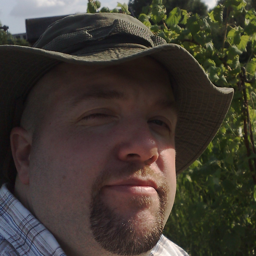

In [6]:
# Grabs the image paths from the dataset.
Image_Paths = [img for img in os.listdir(root_path)]
Image.open(os.path.join(root_path, Image_Paths[50128]))

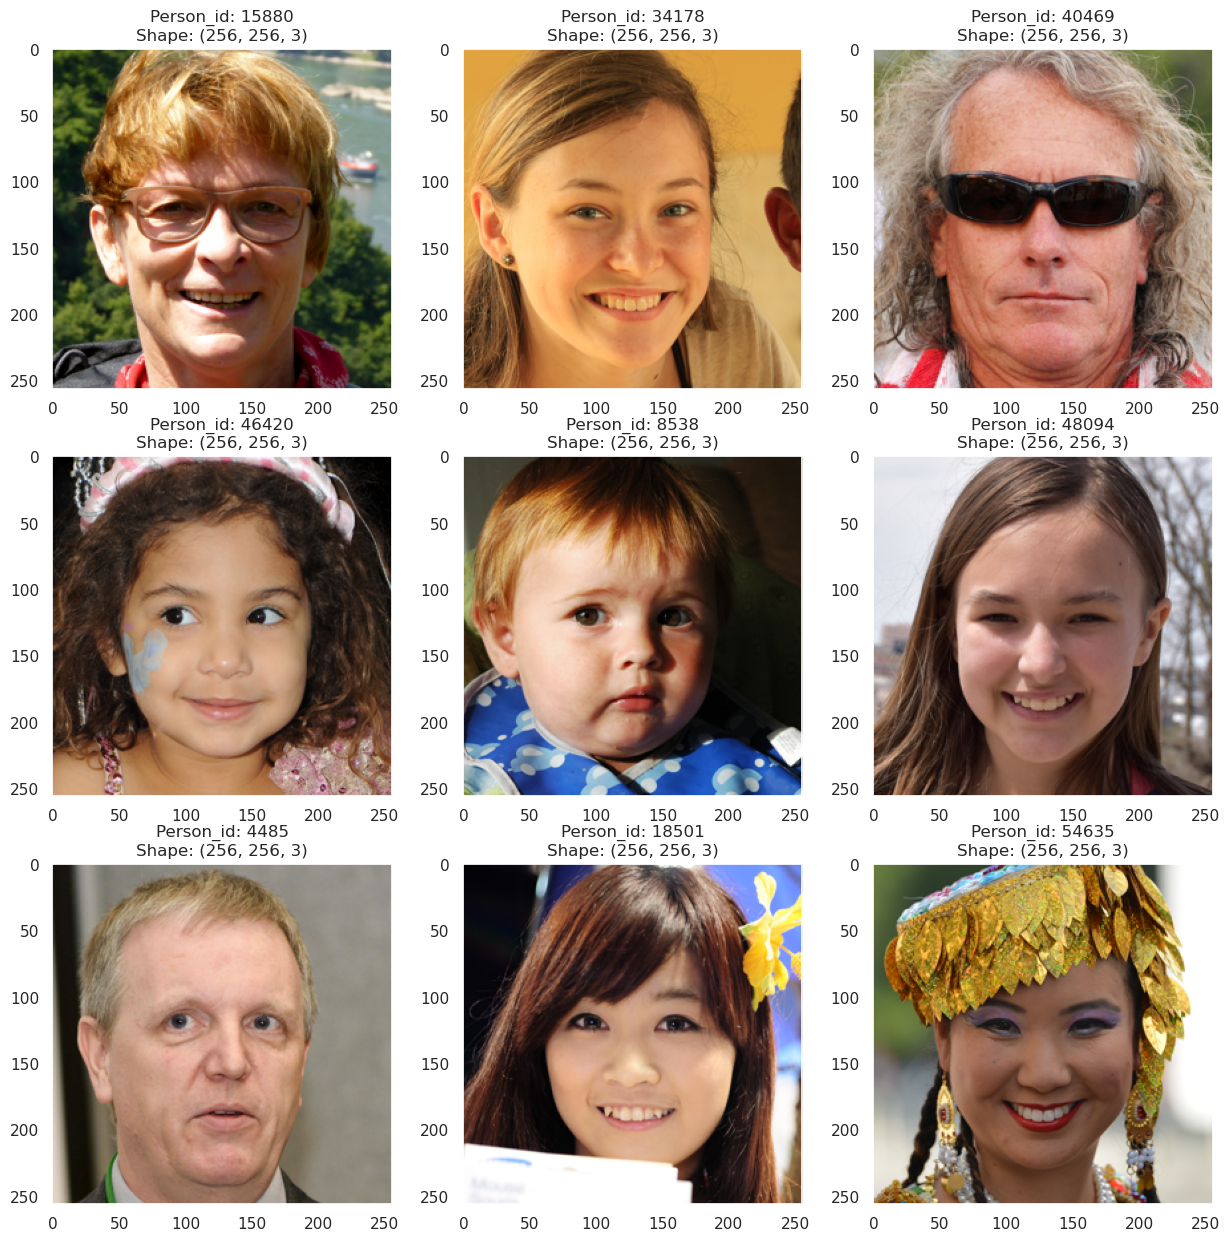

In [8]:
# Plots the Faces
plt.rcParams["axes.grid"] = False
fig = plot_random_persons(Image_Paths, sample = 9)